In [1]:
# Copyright 2021 IITK EE604A Image Processing. All Rights Reserved.
# 
# Licensed under the MIT License. Use and/or modification of this code outside of EE604 must reference:
#
# © IITK EE604A Image Processing 
#
# Author: Dheeraj Bharti, Chiranjeev Prachand and Prof T. Sandhan, Department of Electrical Engineering, IIT Kanpur

Q2. Canny Edge Detection

In this question we will implement the canny edge detector. For the resources you can refer to the class slides or some links given below.

References:

1) Canny, J., A Computational Approach To Edge Detection, IEEE Transactions on Pattern Analysis and Machine Intelligence, 8(6):679–698, 1986.

2)  Zhou, P., Ye, W., & Wang, Q. (2011). An Improved Canny Algorithm for Edge Detection. Journal of Computational Information Systems, 7(5), 1516-1523.

3) https://docs.opencv.org/4.5.1/da/d22/tutorial_py_canny.html

4) http://masters.donntu.org/2010/fknt/chudovskaja/library/article5.htm

4) https://en.wikipedia.org/wiki/Canny_edge_detector

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def gaussianFilter(img, kernel_size=5, sigma=3):
    '''
    Write a program to implement gaussian filter. You have to assume square kernels.
    
    Inputs:
    + img - grayscaled image of size N x N
          - values between [0, 255] - 'uint8'
    + kernel_size - size of the kernel window which should be used for smoothing. 
    + sigma - sigma parameter for gaussian kernel
    
    Ouputs:
    + out_img - smoothed grayscaled image of size N x N
              - values between [0, 255] - 'uint8'
    
    Allowed modules:
    + Basic numpy operations
    + cv2.filter2D() to perform 2D convolution
    + cv2.getGaussianKernel(). Note that this will give you 1D gaussian.
    
    Hint:
    + Not needed.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    x = cv2.getGaussianKernel(kernel_size, sigma)
    y = cv2.getGaussianKernel(kernel_size, sigma)
    kernel = x.dot(y.T)
    #out_img = cv2.filter2D(img,-1,kernel)
    out_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    out_img.astype(int)

    #############################
    # End your code here ########
    #############################    
    
    return out_img

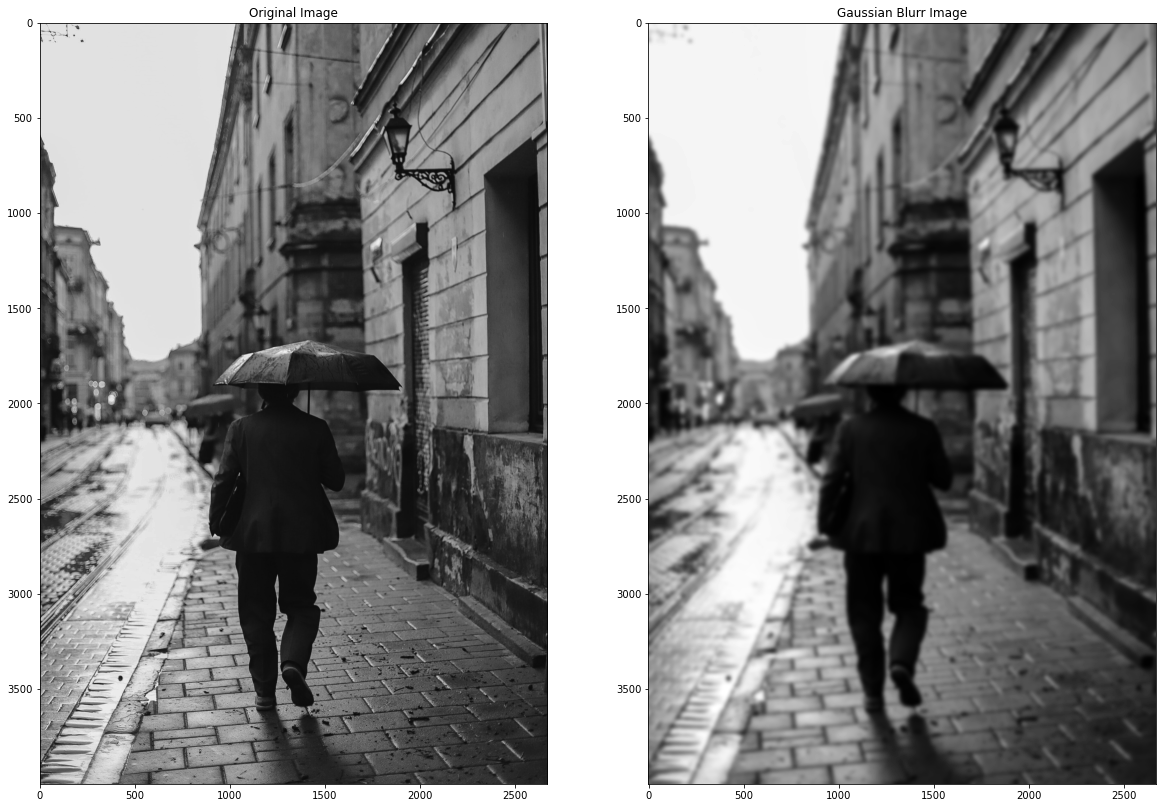

In [4]:
# To check if Gaussian filter blurs or not
# Taking a large kernel with reasonable  sigma to notice the blurr
kernel_size=50
sigma=10

im = cv2.imread('im2.jpg')
im1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im2 = gaussianFilter(im1, kernel_size, sigma)

# Display n see
plt.figure(figsize = (20,20))
plt.subplot(121),plt.imshow(im1,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(im2,cmap = 'gray')
plt.title('Gaussian Blurr Image')
plt.show()


In [5]:
def detect_edge_canny(img, lt, ht):
    '''
    Write a program to detect egdes using the canny algorithm. Pseudo code is given
    for your help

    Inputs:
    - img     - np array of guassian filttered grayscale image
    - lt      - lower threshold for hysteresis linking
    - ht      - higher threshold for hysteresis linking

    Outputs:
    - img_edge  - np array of the image with edges

    Allowed modules:
    - Numpy, cv, math
    - you are not allowed to use cv2.Canny() or any other direct implementations

    '''

    #############################
    # Start your code from here #
    #############################
    n_rows = img.shape[0]
    n_cols = img.shape[1]

    # 1) Start with filtering the image with Sobel kernel both in x and y direction
    #    and store the images as Mx and My.
    Sobel_x =np.array( [[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Sobel_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Mx = cv2.filter2D(img,-1,Sobel_x)
    My = cv2.filter2D(img,-1,Sobel_y)

    # 2) Find the gradient magnitude M and angle theta for each pixel by formulas 
    #    explained in lecture. Also round off the angle to 0, 45, 90, 135 degrees.

    M = np.hypot(Mx, My)
    #M = M / M.max() * 255
    theta = np.arctan2(My, Mx)
    theta = theta * 180. / np.pi
    theta[theta < 0] += 180

    for i in range(n_rows):
        for j in range(n_cols):
            #angle 0
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                theta[i,j] = 0
            #angle 45
            elif (22.5 <= theta[i,j] < 67.5):
                theta[i,j] = 45
            #angle 90
            elif (67.5 <= theta[i,j] < 112.5):
                theta[i,j] = 90
            #angle 135
            elif (112.5 <= theta[i,j] < 157.5):
                theta[i,j] = 135

    theta = theta.astype(int)

    # 3) Non maximum Supression -
    #   3.1) Check if every pixel is local maximum in the gradient direction theta
    #   3.2) if it is maximum take that pixel as edge make the value 255 and assign
    #        zero to all other pixels in that direction. so that we get a single 
    #        pixel edge
    nms_im = np.zeros((n_rows, n_cols));
    for i in range(1,n_rows-1):
        for j in range(1,n_cols-1):  
            if theta[i,j] == 0:
                q = img[i, j+1]
                r = img[i, j-1]
            #angle 45
            elif theta[i,j] == 45:
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            #angle 90
            elif theta[i,j] == 90:
                q = img[i+1, j]
                r = img[i-1, j]
            #angle 135
            elif theta[i,j] == 135:
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if (M[i,j] >= q) and (M[i,j] >= r):
                nms_im[i,j] = M[i,j]
            else:
                nms_im[i,j] = 0

    # 4) Linking - 
    #    use the process of hysteresis linking explained in the lecture for discarding
    #    weak edges and selecting the strong edges using the threshold lt and ht

    link_im = np.zeros((n_rows, n_cols));
    for i in range(1,n_rows-1):
        for j in range(1,n_cols-1):  
            if nms_im[i,j] < lt:
                link_im[i,j] = 0
            elif nms_im[i,j] >= ht:
                link_im[i,j] = 255
            elif nms_im[i,j] >= lt and nms_im[i,j] < ht:
                if theta[i,j] == 0:
                    q = nms_im[i+1, j] 
                    r = nms_im[i-1, j]
                #angle 45
                elif theta[i,j] == 45:
                    q = nms_im[i-1, j-1]
                    r = nms_im[i+1, j+1]
                #angle 90
                elif theta[i,j] == 90:
                    q = nms_im[i, j+1]
                    r = nms_im[i, j-1]
                #angle 135
                elif theta[i,j] == 135:
                    q = nms_im[i-1, j+1]
                    r = nms_im[i+1, j-1]

                if (q >= ht) or (r >= ht):
                    link_im[i,j] = 255
                else:
                    link_im[i,j] = 0

    img_edge = link_im

    #############################
    # End your code here ########
    #############################    

    return img_edge

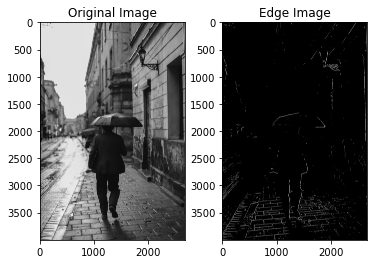

In [6]:
im = cv2.imread('im2.jpg')
im1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im2 = gaussianFilter(im1, 5, 1.4)
im_edge = detect_edge_canny(im2, 50, 100)


plt.subplot(121),plt.imshow(im1,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(im_edge,cmap = 'gray')
plt.title('Edge Image')
plt.show()